# Analysis of Noise-Perturbed Student-Teacher Network

This notebook analyses the results from the grid search over noise levels in the feedforward noisy units experiment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.dpi"] = 100

In [2]:
# Path to grid search results
grid_search_dir = Path(
    "/tungstenfs/scratch/gzenke/bedfrory/dp-simulations/activity-fitting/feedforward-noisy-units"
)

# Find all run directories
run_dirs = sorted(
    [
        d
        for d in grid_search_dir.iterdir()
        if d.is_dir() and d.name.startswith("noise-fraction-")
    ]
)
print(f"Found {len(run_dirs)} runs:")
for d in run_dirs:
    print(f"  {d.name}")

Found 10 runs:
  noise-fraction-0.05
  noise-fraction-0.10
  noise-fraction-0.15
  noise-fraction-0.20
  noise-fraction-0.25
  noise-fraction-0.30
  noise-fraction-0.35
  noise-fraction-0.40
  noise-fraction-0.45
  noise-fraction-0.50


In [3]:
# Extract noise levels and load final metrics from each run
results = []

for run_dir in run_dirs:
    # Extract noise fraction from directory name
    match = re.search(r"noise-fraction-([\d.]+)", run_dir.name)
    if match:
        noise_fraction = float(match.group(1))
    else:
        continue

    # Load training metrics
    metrics_path = run_dir / "training_metrics.csv"
    if not metrics_path.exists():
        print(f"Warning: {metrics_path} not found, skipping")
        continue

    df = pd.read_csv(metrics_path)

    # Get final row (last epoch)
    final_row = df.iloc[-1]

    results.append(
        {
            "noise_fraction": noise_fraction,
            "final_epoch": final_row["epoch"],
            # Scaling factors - learned values
            "exc_to_exc_value": final_row[
                "scaling_factors/excitatory_to_excitatory/value"
            ],
            "exc_to_inh_value": final_row[
                "scaling_factors/excitatory_to_inhibitory/value"
            ],
            "inh_to_exc_value": final_row[
                "scaling_factors/inhibitory_to_excitatory/value"
            ],
            "inh_to_inh_value": final_row[
                "scaling_factors/inhibitory_to_inhibitory/value"
            ],
            "mitral_to_exc_value": final_row[
                "scaling_factors/mitral_to_excitatory/value"
            ],
            "mitral_to_inh_value": final_row[
                "scaling_factors/mitral_to_inhibitory/value"
            ],
            # Scaling factors - targets
            "exc_to_exc_target": final_row[
                "scaling_factors/excitatory_to_excitatory/target"
            ],
            "exc_to_inh_target": final_row[
                "scaling_factors/excitatory_to_inhibitory/target"
            ],
            "inh_to_exc_target": final_row[
                "scaling_factors/inhibitory_to_excitatory/target"
            ],
            "inh_to_inh_target": final_row[
                "scaling_factors/inhibitory_to_inhibitory/target"
            ],
            "mitral_to_exc_target": final_row[
                "scaling_factors/mitral_to_excitatory/target"
            ],
            "mitral_to_inh_target": final_row[
                "scaling_factors/mitral_to_inhibitory/target"
            ],
            # Loss
            "final_loss": final_row["total_loss"],
        }
    )

results_df = pd.DataFrame(results).sort_values("noise_fraction").reset_index(drop=True)
print(f"\nLoaded results from {len(results_df)} runs")
results_df


Loaded results from 8 runs


,noise_fraction,final_epoch,exc_to_exc_value,exc_to_inh_value,inh_to_exc_value,inh_to_inh_value,mitral_to_exc_value,mitral_to_inh_value,exc_to_exc_target,exc_to_inh_target,inh_to_exc_target,inh_to_inh_target,mitral_to_exc_target,mitral_to_inh_target,final_loss
0,0.05,4000.0,0.699269,1.736303,1.645113,1.781052,1.324690,0.686567,0.708884,1.746334,1.672414,1.808238,1.332911,0.693316,0.041558
1,0.10,4000.0,0.688106,1.726734,1.618398,1.756541,1.316108,0.678363,0.708884,1.746334,1.672414,1.808238,1.332911,0.693316,0.081595
2,0.15,4000.0,0.675989,1.714437,1.589265,1.742010,1.301447,0.672277,0.708884,1.746334,1.672414,1.808238,1.332911,0.693316,0.121403
3,0.20,4000.0,0.663102,1.696950,1.563021,1.716137,1.285875,0.661379,0.708884,1.746334,1.672414,1.808238,1.332911,0.693316,0.162877
4,0.25,4000.0,0.649374,1.688114,1.535960,1.695806,1.267113,0.647431,0.708884,1.746334,1.672414,1.808238,1.332911,0.693316,0.206811
5,0.30,4000.0,0.631358,1.679428,1.502524,1.672545,1.242353,0.629895,0.708884,1.746334,1.672414,1.808238,1.332911,0.693316,0.253344
6,0.35,4000.0,0.614107,1.668648,1.463528,1.647540,1.204188,0.611310,0.708884,1.746334,1.672414,1.808238,1.332911,0.693316,0.302850
7,0.40,4000.0,0.593754,1.653162,1.415872,1.616135,1.158573,0.590549,0.708884,1.746334,1.672414,1.808238,1.332911,0.693316,0.354368


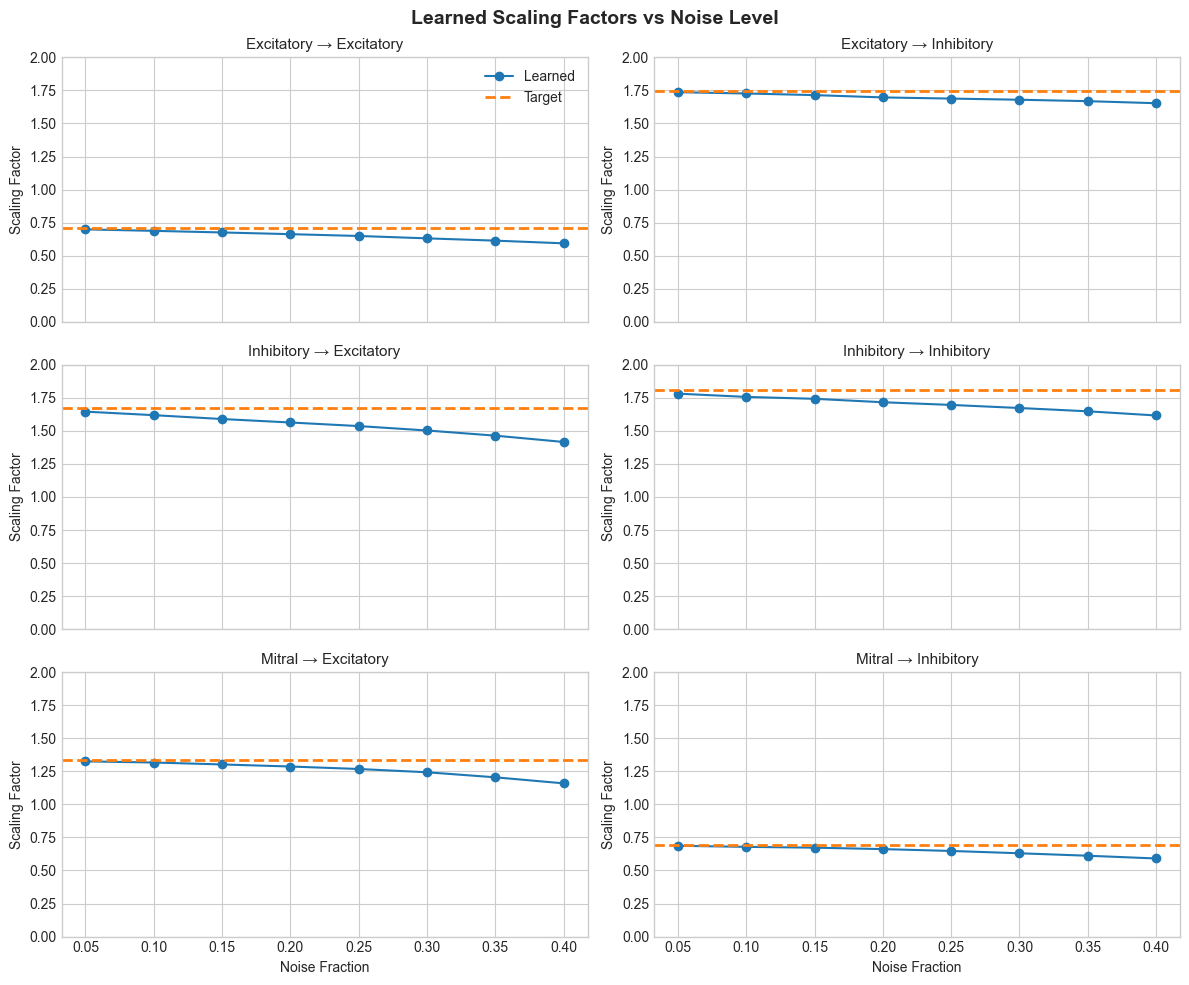

In [4]:
# Plot learned scaling factors vs noise level (3x2 subplot)
fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=True)

scaling_factor_pairs = [
    ("exc_to_exc", "Excitatory → Excitatory"),
    ("exc_to_inh", "Excitatory → Inhibitory"),
    ("inh_to_exc", "Inhibitory → Excitatory"),
    ("inh_to_inh", "Inhibitory → Inhibitory"),
    ("mitral_to_exc", "Mitral → Excitatory"),
    ("mitral_to_inh", "Mitral → Inhibitory"),
]

noise_levels = results_df["noise_fraction"].values

for idx, (key, title) in enumerate(scaling_factor_pairs):
    ax = axes.flat[idx]

    # Get values and targets
    values = results_df[f"{key}_value"].values
    targets = results_df[f"{key}_target"].values

    # Plot learned values
    ax.plot(noise_levels, values, "o-", color="C0", label="Learned", markersize=6)

    # Plot target (should be constant across noise levels)
    ax.axhline(y=targets[0], color="C1", linestyle="--", linewidth=2, label="Target")

    ax.set_title(title, fontsize=11)
    ax.set_ylabel("Scaling Factor")
    ax.set_ylim(0, 2)

    if idx >= 4:  # Bottom row
        ax.set_xlabel("Noise Fraction")

    if idx == 0:
        ax.legend(loc="best")

plt.suptitle("Learned Scaling Factors vs Noise Level", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [5]:
# Scatter plot of teacher vs perturbed weights for noise_frac = 0.4
noise_level_to_plot = 0.40
run_dir = grid_search_dir / f"noise-fraction-{noise_level_to_plot:.2f}"

# Load teacher weights (from symlinked input)
teacher_data = np.load(run_dir / "inputs" / "network_structure.npz")
teacher_ff_weights = teacher_data["feedforward_weights"]  # (1500, 5000)
teacher_rec_weights = teacher_data["recurrent_weights"]  # (5000, 5000)

# Concatenate to match the training script's format
teacher_weights = np.concatenate(
    [teacher_ff_weights, teacher_rec_weights], axis=0
)  # (6500, 5000)

# Load noise config to get seed
noise_config = np.load(run_dir / "targets" / "weight_noise_config.npz")
noise_frac = float(noise_config["noise_frac"])
seed = int(noise_config["seed"])

print(f"Noise fraction: {noise_frac}")
print(f"Seed: {seed}")
print(f"Teacher weights shape: {teacher_weights.shape}")


# Apply the same noise function used in training
def apply_weight_noise(weights, noise_frac, rng=None):
    """Apply unbiased multiplicative Gaussian noise to weights."""
    if rng is None:
        rng = np.random.default_rng()
    multiplier = 1 + noise_frac * rng.standard_normal(weights.shape)
    multiplier = np.clip(multiplier, 0, 2)
    return weights * multiplier


# Reconstruct the noisy weights
weight_noise_rng = np.random.default_rng(seed)
perturbed_weights = apply_weight_noise(
    teacher_weights, noise_frac, rng=weight_noise_rng
)

print(f"Perturbed weights shape: {perturbed_weights.shape}")

Noise fraction: 0.4
Seed: 44
Teacher weights shape: (6500, 5000)
Perturbed weights shape: (6500, 5000)


Number of non-zero weights: 1,852,500
Subsampled to 50,000 points for plotting


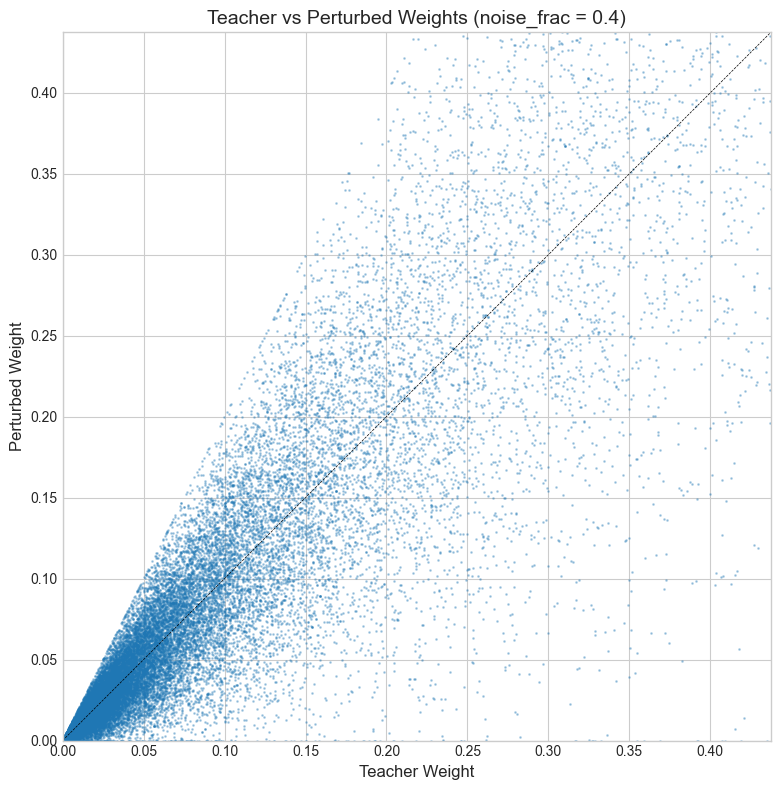


Weight statistics:
  Teacher mean: 0.1043, std: 0.3254
  Perturbed mean: 0.1040, std: 0.3412
  Correlation: 0.9159


In [6]:
# Scatter plot: Teacher vs Perturbed weights
# Only plot non-zero weights (where connections exist)
mask = teacher_weights != 0
teacher_flat = teacher_weights[mask]
perturbed_flat = perturbed_weights[mask]

print(f"Number of non-zero weights: {len(teacher_flat):,}")

# Subsample for plotting if too many points
max_points = 50000
if len(teacher_flat) > max_points:
    idx = np.random.choice(len(teacher_flat), max_points, replace=False)
    teacher_sample = teacher_flat[idx]
    perturbed_sample = perturbed_flat[idx]
    print(f"Subsampled to {max_points:,} points for plotting")
else:
    teacher_sample = teacher_flat
    perturbed_sample = perturbed_flat

fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(teacher_sample, perturbed_sample, alpha=0.3, s=1, c="C0")

# Use 95th percentile for axis limits
upper_lim = np.percentile(np.concatenate([teacher_flat, perturbed_flat]), 95)
lims = [0, upper_lim]

ax.plot(lims, lims, "k--", linewidth=0.5)

ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Teacher Weight", fontsize=12)
ax.set_ylabel("Perturbed Weight", fontsize=12)
ax.set_title(f"Teacher vs Perturbed Weights (noise_frac = {noise_frac})", fontsize=14)
ax.set_aspect("equal")

plt.tight_layout()
plt.show()

# Print some statistics
print("\nWeight statistics:")
print(f"  Teacher mean: {teacher_flat.mean():.4f}, std: {teacher_flat.std():.4f}")
print(f"  Perturbed mean: {perturbed_flat.mean():.4f}, std: {perturbed_flat.std():.4f}")
print(f"  Correlation: {np.corrcoef(teacher_flat, perturbed_flat)[0, 1]:.4f}")

Teacher mean firing rate: 1.168 Hz


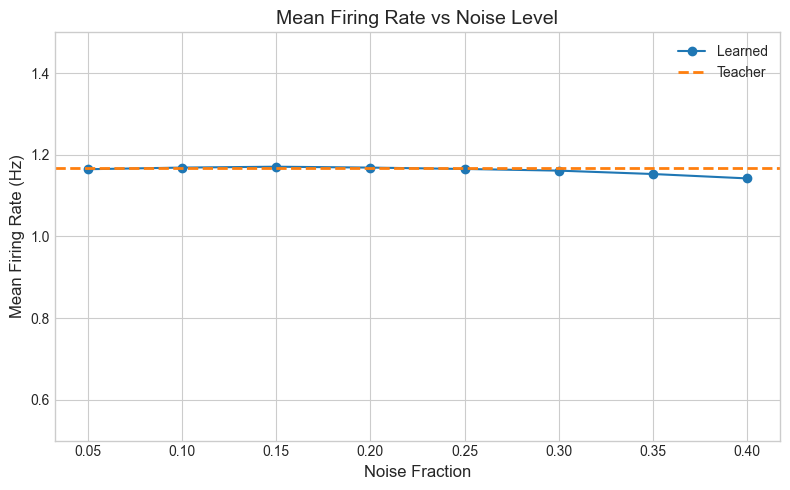

In [7]:
# Plot mean firing rate vs noise level (with teacher reference)
import zarr

# Load teacher firing rate from the teacher spike data (symlinked in inputs folder)
teacher_zarr_path = (
    grid_search_dir / "noise-fraction-0.05" / "inputs" / "spike_data.zarr"
)
teacher_zarr = zarr.open(store=teacher_zarr_path, mode="r")
teacher_spikes = teacher_zarr["output_spikes"][:]  # (batch, time, neurons)
dt = teacher_zarr.attrs["dt"]  # ms

# Compute teacher mean firing rate in Hz
teacher_spike_count = teacher_spikes.sum()
total_time_s = teacher_spikes.shape[0] * teacher_spikes.shape[1] * dt / 1000.0
n_neurons = teacher_spikes.shape[2]
teacher_mean_rate = teacher_spike_count / (total_time_s * n_neurons)

print(f"Teacher mean firing rate: {teacher_mean_rate:.3f} Hz")

# Load learned firing rates from each run
results_with_fr = []

for run_dir in run_dirs:
    match = re.search(r"noise-fraction-([\d.]+)", run_dir.name)
    if match:
        noise_fraction = float(match.group(1))
    else:
        continue

    metrics_path = run_dir / "training_metrics.csv"
    if not metrics_path.exists():
        continue

    df = pd.read_csv(metrics_path)
    final_row = df.iloc[-1]

    results_with_fr.append(
        {
            "noise_fraction": noise_fraction,
            "firing_rate_mean": final_row["firing_rate/mean"],
        }
    )

fr_df = (
    pd.DataFrame(results_with_fr).sort_values("noise_fraction").reset_index(drop=True)
)

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(
    fr_df["noise_fraction"],
    fr_df["firing_rate_mean"],
    "o-",
    color="C0",
    markersize=6,
    label="Learned",
)
ax.axhline(
    y=teacher_mean_rate, color="C1", linestyle="--", linewidth=2, label="Teacher"
)

ax.set_xlabel("Noise Fraction", fontsize=12)
ax.set_ylabel("Mean Firing Rate (Hz)", fontsize=12)
ax.set_title("Mean Firing Rate vs Noise Level", fontsize=14)
ax.set_ylim(0.5, 1.5)
ax.legend(loc="best")

plt.tight_layout()
plt.show()

## Convergence Analysis: Different Target Scaling Factors

This section analyses the convergence behaviour of the network when starting from the same initial conditions but with different target scaling factors. The question is: does the network converge to the correct target regardless of what the target is?

In [8]:
# Load convergence analysis data from convexity check runs
convexity_dir = Path(
    "/tungstenfs/scratch/gzenke/bedfrory/dp-simulations/activity-fitting/feedforward-noisy-units-convexity-check"
)

# Find all seed directories
seed_dirs = sorted(
    [
        d
        for d in convexity_dir.iterdir()
        if d.is_dir() and d.name.startswith("convexity-check-seed-")
    ]
)
print(f"Found {len(seed_dirs)} convexity check runs")

# Load trajectories from all runs
scaling_factor_names = [
    ("excitatory_to_excitatory", "Exc → Exc"),
    ("excitatory_to_inhibitory", "Exc → Inh"),
    ("inhibitory_to_excitatory", "Inh → Exc"),
    ("inhibitory_to_inhibitory", "Inh → Inh"),
    ("mitral_to_excitatory", "Mitral → Exc"),
    ("mitral_to_inhibitory", "Mitral → Inh"),
]

trajectories = {}
for seed_dir in seed_dirs:
    seed = int(seed_dir.name.split("-")[-1])
    metrics_path = seed_dir / "training_metrics.csv"
    if not metrics_path.exists():
        print(f"Warning: {metrics_path} not found, skipping")
        continue
    
    df = pd.read_csv(metrics_path)
    trajectories[seed] = {
        "epochs": df["epoch"].values,
    }
    
    for sf_key, _ in scaling_factor_names:
        trajectories[seed][f"{sf_key}_value"] = df[f"scaling_factors/{sf_key}/value"].values
        trajectories[seed][f"{sf_key}_target"] = df[f"scaling_factors/{sf_key}/target"].values[0]

print(f"Loaded trajectories for seeds: {sorted(trajectories.keys())}")

Found 10 convexity check runs
Loaded trajectories for seeds: [42, 43, 44, 45, 46, 47, 48, 49, 50, 51]


In [9]:
# Load and visualize the noisy weights used in convexity check
example_seed = 42
example_run_dir = convexity_dir / f"convexity-check-seed-{example_seed}"

# Load teacher weights
teacher_data_conv = np.load(example_run_dir / "inputs" / "network_structure.npz")
teacher_ff_weights = teacher_data_conv["feedforward_weights"]
teacher_rec_weights = teacher_data_conv["recurrent_weights"]
teacher_weights_conv = np.concatenate([teacher_ff_weights, teacher_rec_weights], axis=0)

# Load noise config
noise_config = np.load(example_run_dir / "targets" / "weight_noise_config.npz")
noise_frac_conv = float(noise_config["noise_frac"])
noise_seed = int(noise_config["seed"])

print(f"Convexity check weight noise:")
print(f"  Noise fraction: {noise_frac_conv}")
print(f"  Seed: {noise_seed}")
print(f"  Teacher weights shape: {teacher_weights_conv.shape}")

# Apply the same noise function (variance-preserving)
def apply_weight_noise_vp(weights, noise_frac, rng=None):
    """Apply unbiased multiplicative Gaussian noise to weights (variance-preserving)."""
    if rng is None:
        rng = np.random.default_rng()
    
    orig_std = weights.std()
    multiplier = 1 + noise_frac * rng.standard_normal(weights.shape)
    multiplier = np.clip(multiplier, 0, 2)
    noisy_weights = weights * multiplier
    
    # Variance preservation
    if orig_std > 0:
        noisy_mean = noisy_weights.mean()
        noisy_std = noisy_weights.std()
        if noisy_std > 0:
            noisy_weights = noisy_mean + (noisy_weights - noisy_mean) * (orig_std / noisy_std)
    
    return noisy_weights

# Reconstruct the noisy weights
weight_noise_rng = np.random.default_rng(noise_seed)
perturbed_weights_conv = apply_weight_noise_vp(
    teacher_weights_conv, noise_frac_conv, rng=weight_noise_rng
)

print(f"Perturbed weights shape: {perturbed_weights_conv.shape}")

Convexity check weight noise:
  Noise fraction: 0.4
  Seed: 42
  Teacher weights shape: (6500, 5000)
Perturbed weights shape: (6500, 5000)


Number of non-zero weights: 1,852,500
Subsampled to 50,000 points for plotting


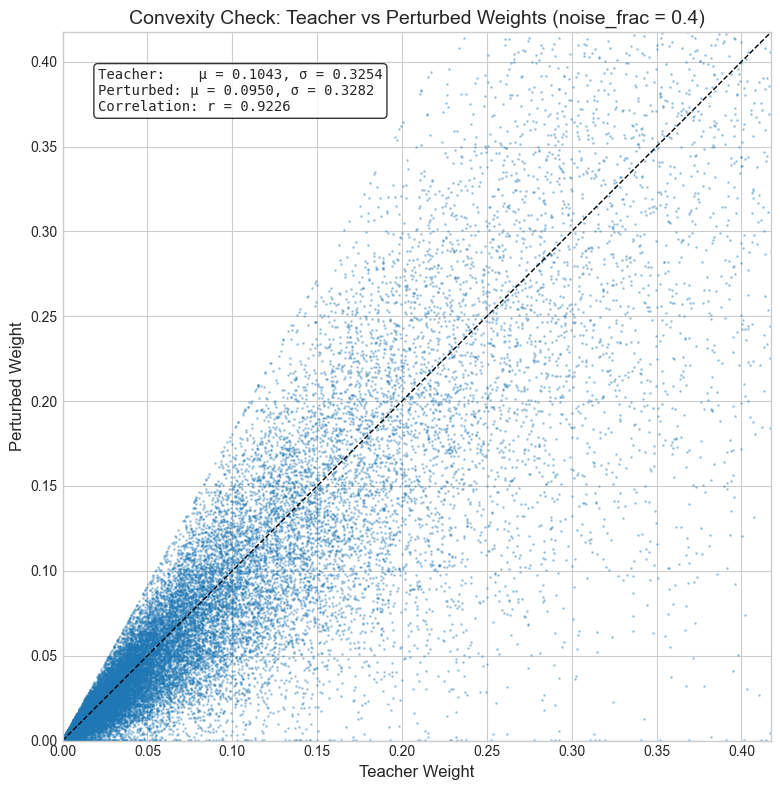

In [10]:
# Scatter plot: Teacher vs Perturbed weights with mean/std annotations
mask_conv = teacher_weights_conv != 0
teacher_flat_conv = teacher_weights_conv[mask_conv]
perturbed_flat_conv = perturbed_weights_conv[mask_conv]

print(f"Number of non-zero weights: {len(teacher_flat_conv):,}")

# Compute statistics
teacher_mean = teacher_flat_conv.mean()
teacher_std = teacher_flat_conv.std()
perturbed_mean = perturbed_flat_conv.mean()
perturbed_std = perturbed_flat_conv.std()
correlation = np.corrcoef(teacher_flat_conv, perturbed_flat_conv)[0, 1]

# Subsample for plotting
max_points = 50000
if len(teacher_flat_conv) > max_points:
    idx = np.random.choice(len(teacher_flat_conv), max_points, replace=False)
    teacher_sample_conv = teacher_flat_conv[idx]
    perturbed_sample_conv = perturbed_flat_conv[idx]
    print(f"Subsampled to {max_points:,} points for plotting")
else:
    teacher_sample_conv = teacher_flat_conv
    perturbed_sample_conv = perturbed_flat_conv

fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(teacher_sample_conv, perturbed_sample_conv, alpha=0.3, s=1, c="C0")

# Use 95th percentile for axis limits
upper_lim = np.percentile(np.concatenate([teacher_flat_conv, perturbed_flat_conv]), 95)
lims = [0, upper_lim]

ax.plot(lims, lims, "k--", linewidth=1, label="Identity")

ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Teacher Weight", fontsize=12)
ax.set_ylabel("Perturbed Weight", fontsize=12)
ax.set_title(f"Convexity Check: Teacher vs Perturbed Weights (noise_frac = {noise_frac_conv})", fontsize=14)
ax.set_aspect("equal")

# Add text box with statistics
stats_text = (
    f"Teacher:    μ = {teacher_mean:.4f}, σ = {teacher_std:.4f}\n"
    f"Perturbed: μ = {perturbed_mean:.4f}, σ = {perturbed_std:.4f}\n"
    f"Correlation: r = {correlation:.4f}"
)
ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

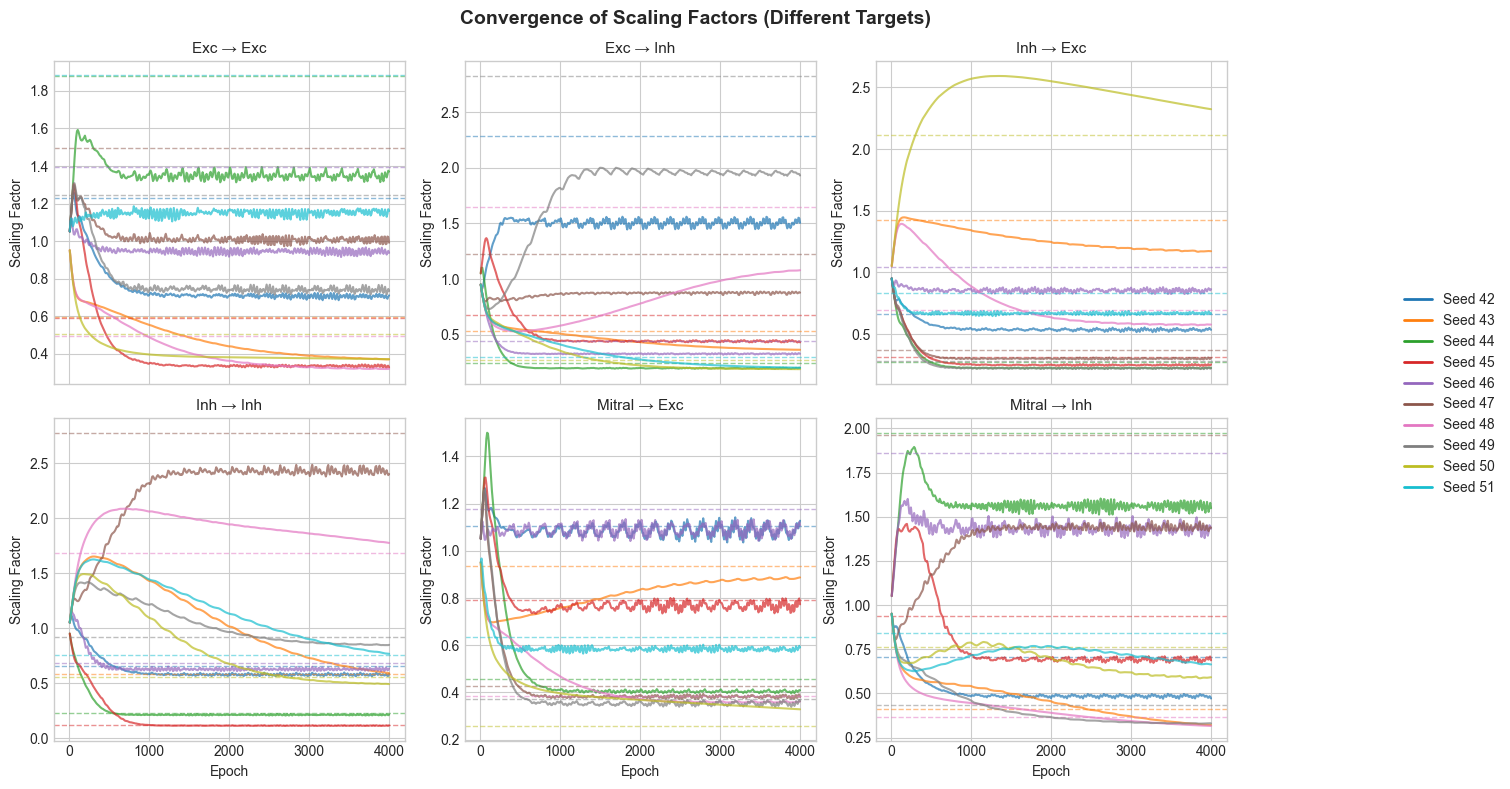

In [11]:
# Plot 1: Raw trajectories with targets for each scaling factor
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True)

seeds = sorted(trajectories.keys())
colors = plt.cm.tab10(np.linspace(0, 1, len(seeds)))

for idx, (sf_key, sf_label) in enumerate(scaling_factor_names):
    ax = axes.flat[idx]
    
    for seed_idx, seed in enumerate(seeds):
        traj = trajectories[seed]
        epochs = traj["epochs"]
        values = traj[f"{sf_key}_value"]
        target = traj[f"{sf_key}_target"]
        
        # Plot trajectory
        ax.plot(epochs, values, color=colors[seed_idx], alpha=0.7, linewidth=1.5)
        # Plot target as horizontal dashed line
        ax.axhline(y=target, color=colors[seed_idx], linestyle="--", alpha=0.5, linewidth=1)
    
    ax.set_title(sf_label, fontsize=11)
    ax.set_ylabel("Scaling Factor")
    if idx >= 3:
        ax.set_xlabel("Epoch")

# Add a legend showing seed colors
handles = [plt.Line2D([0], [0], color=colors[i], linewidth=2) for i in range(len(seeds))]
labels = [f"Seed {s}" for s in seeds]
fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.08, 0.5))

plt.suptitle("Convergence of Scaling Factors (Different Targets)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.subplots_adjust(right=0.88)
plt.show()

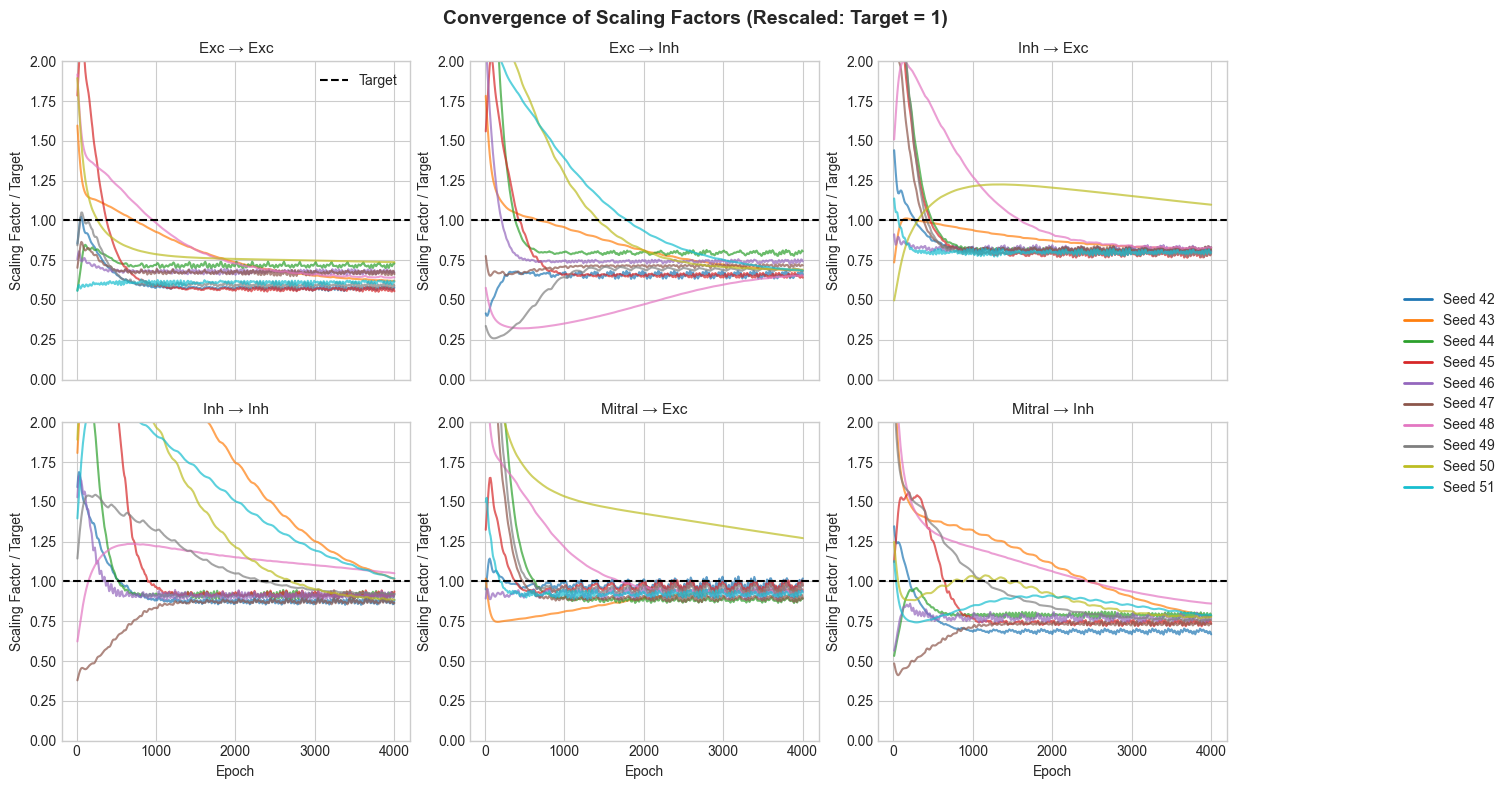

In [12]:
# Plot 2: Rescaled trajectories (targets normalized to 1)
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True)

for idx, (sf_key, sf_label) in enumerate(scaling_factor_names):
    ax = axes.flat[idx]
    
    for seed_idx, seed in enumerate(seeds):
        traj = trajectories[seed]
        epochs = traj["epochs"]
        values = traj[f"{sf_key}_value"]
        target = traj[f"{sf_key}_target"]
        
        # Rescale so target = 1
        rescaled_values = values / target
        
        # Plot rescaled trajectory
        ax.plot(epochs, rescaled_values, color=colors[seed_idx], alpha=0.7, linewidth=1.5)
    
    # Plot target line at 1
    ax.axhline(y=1.0, color="black", linestyle="--", linewidth=1.5, label="Target")
    
    ax.set_title(sf_label, fontsize=11)
    ax.set_ylabel("Scaling Factor / Target")
    ax.set_ylim(0, 2)
    if idx >= 3:
        ax.set_xlabel("Epoch")
    if idx == 0:
        ax.legend(loc="upper right")

# Add a legend showing seed colors
handles = [plt.Line2D([0], [0], color=colors[i], linewidth=2) for i in range(len(seeds))]
labels = [f"Seed {s}" for s in seeds]
fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.08, 0.5))

plt.suptitle("Convergence of Scaling Factors (Rescaled: Target = 1)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.subplots_adjust(right=0.88)
plt.show()

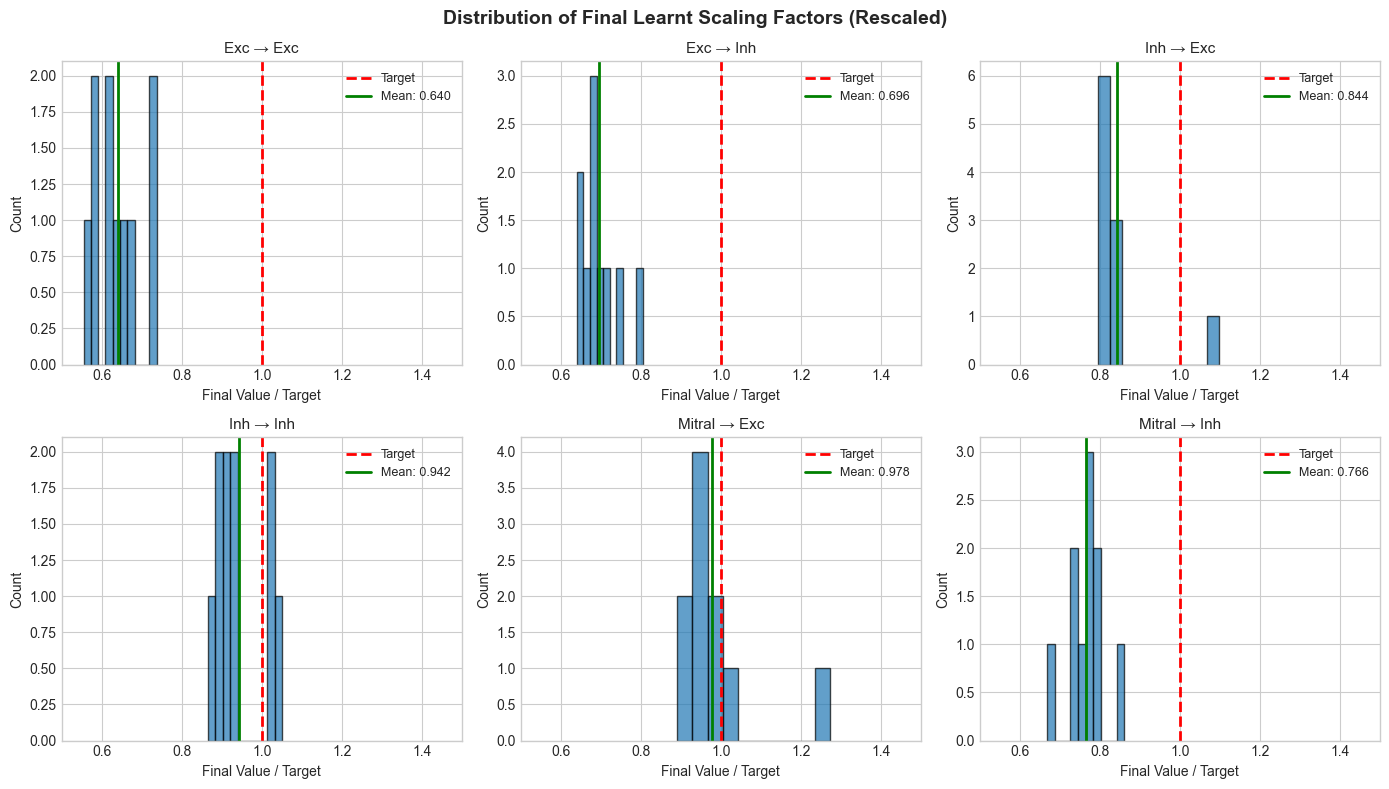


Summary Statistics (Final Value / Target):
------------------------------------------------------------
Exc → Exc           : mean=0.6400, std=0.0582, min=0.5550, max=0.7376
Exc → Inh           : mean=0.6961, std=0.0462, min=0.6401, max=0.8057
Inh → Exc           : mean=0.8442, std=0.0858, min=0.7943, max=1.0989
Inh → Inh           : mean=0.9423, std=0.0611, min=0.8650, max=1.0516
Mitral → Exc        : mean=0.9784, std=0.1044, min=0.8911, max=1.2724
Mitral → Inh        : mean=0.7657, std=0.0470, min=0.6675, max=0.8613


In [13]:
# Plot 3: Distribution of final learnt scaling factors (rescaled)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

for idx, (sf_key, sf_label) in enumerate(scaling_factor_names):
    ax = axes.flat[idx]
    
    # Collect final rescaled values
    final_rescaled = []
    for seed in seeds:
        traj = trajectories[seed]
        final_value = traj[f"{sf_key}_value"][-1]
        target = traj[f"{sf_key}_target"]
        final_rescaled.append(final_value / target)
    
    final_rescaled = np.array(final_rescaled)
    
    # Plot histogram
    ax.hist(final_rescaled, bins=10, edgecolor="black", alpha=0.7, color="C0")
    
    # Add vertical line at target (1.0)
    ax.axvline(x=1.0, color="red", linestyle="--", linewidth=2, label="Target")
    
    # Add mean line
    mean_val = np.mean(final_rescaled)
    ax.axvline(x=mean_val, color="green", linestyle="-", linewidth=2, label=f"Mean: {mean_val:.3f}")
    
    ax.set_title(sf_label, fontsize=11)
    ax.set_xlabel("Final Value / Target")
    ax.set_ylabel("Count")
    ax.set_xlim(0.5, 1.5)
    ax.legend(loc="upper right", fontsize=9)

plt.suptitle("Distribution of Final Learnt Scaling Factors (Rescaled)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics (Final Value / Target):")
print("-" * 60)
for sf_key, sf_label in scaling_factor_names:
    final_rescaled = []
    for seed in seeds:
        traj = trajectories[seed]
        final_value = traj[f"{sf_key}_value"][-1]
        target = traj[f"{sf_key}_target"]
        final_rescaled.append(final_value / target)
    
    final_rescaled = np.array(final_rescaled)
    print(f"{sf_label:20s}: mean={np.mean(final_rescaled):.4f}, std={np.std(final_rescaled):.4f}, "
          f"min={np.min(final_rescaled):.4f}, max={np.max(final_rescaled):.4f}")

In [14]:
# Load consistency check data (starting at correct values)
consistency_dir = Path(
    "/tungstenfs/scratch/gzenke/bedfrory/dp-simulations/activity-fitting/feedforward-noisy-units-consistency-check"
)

consistency_df = pd.read_csv(consistency_dir / "training_metrics.csv")
print(f"Consistency check: {len(consistency_df)} epochs")

# Store consistency check trajectory
consistency_traj = {
    "epochs": consistency_df["epoch"].values,
}
for sf_key, _ in scaling_factor_names:
    # For consistency check, target is 1.0, so no rescaling needed
    consistency_traj[f"{sf_key}_value"] = consistency_df[f"scaling_factors/{sf_key}/value"].values
    consistency_traj[f"{sf_key}_target"] = consistency_df[f"scaling_factors/{sf_key}/target"].values[0]

print(f"Consistency check targets: {[consistency_traj[f'{k}_target'] for k, _ in scaling_factor_names]}")

Consistency check: 158 epochs
Consistency check targets: [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]


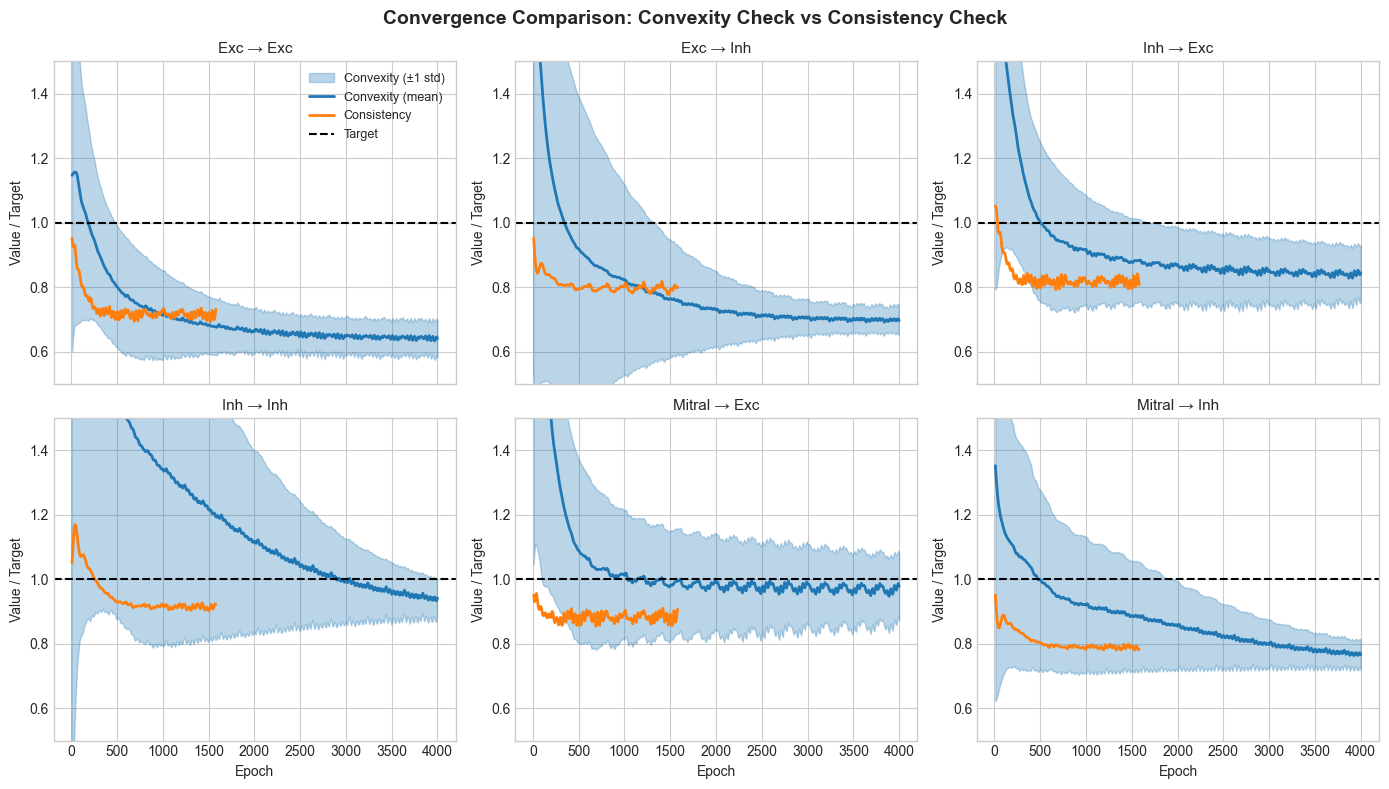

In [15]:
# Plot: Mean ± std of convexity check (rescaled) with consistency check overlaid
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True)

# Get common epoch grid (use the first seed's epochs as reference)
reference_seed = seeds[0]
epochs_ref = trajectories[reference_seed]["epochs"]

for idx, (sf_key, sf_label) in enumerate(scaling_factor_names):
    ax = axes.flat[idx]
    
    # Collect rescaled trajectories from all convexity check seeds
    # Interpolate to common epoch grid if needed
    rescaled_all = []
    for seed in seeds:
        traj = trajectories[seed]
        values = traj[f"{sf_key}_value"]
        target = traj[f"{sf_key}_target"]
        rescaled = values / target
        
        # Interpolate to reference epochs if different length
        if len(traj["epochs"]) != len(epochs_ref):
            rescaled = np.interp(epochs_ref, traj["epochs"], rescaled)
        
        rescaled_all.append(rescaled)
    
    rescaled_all = np.array(rescaled_all)  # (n_seeds, n_epochs)
    
    # Compute mean and std
    mean_traj = np.mean(rescaled_all, axis=0)
    std_traj = np.std(rescaled_all, axis=0)
    
    # Plot mean ± std for convexity check
    ax.fill_between(epochs_ref, mean_traj - std_traj, mean_traj + std_traj, 
                    alpha=0.3, color="C0", label="Convexity (±1 std)")
    ax.plot(epochs_ref, mean_traj, color="C0", linewidth=2, label="Convexity (mean)")
    
    # Plot consistency check (already has target = 1, so no rescaling needed)
    cons_values = consistency_traj[f"{sf_key}_value"]
    cons_target = consistency_traj[f"{sf_key}_target"]
    cons_rescaled = cons_values / cons_target  # Should be values since target = 1
    ax.plot(consistency_traj["epochs"], cons_rescaled, color="C1", linewidth=2, 
            linestyle="-", label="Consistency")
    
    # Plot target line at 1
    ax.axhline(y=1.0, color="black", linestyle="--", linewidth=1.5, label="Target")
    
    ax.set_title(sf_label, fontsize=11)
    ax.set_ylabel("Value / Target")
    ax.set_ylim(0.5, 1.5)
    if idx >= 3:
        ax.set_xlabel("Epoch")
    if idx == 0:
        ax.legend(loc="upper right", fontsize=9)

plt.suptitle("Convergence Comparison: Convexity Check vs Consistency Check", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

### Firing Rate Analysis

The training metrics only log aggregate firing rates (mean, max, min, std across all neurons). We can compute the teacher firing rates split by cell type from the spike data, and compare with the student's aggregate firing rate trajectory.

In [16]:
# Compute teacher firing rates by cell type
# Load cell type indices
network_data = np.load(convexity_dir / "convexity-check-seed-42" / "inputs" / "network_structure.npz")
cell_type_indices = network_data["cell_type_indices"]  # 0 = excitatory, 1 = inhibitory

exc_mask = cell_type_indices == 0
inh_mask = cell_type_indices == 1
print(f"Excitatory neurons: {exc_mask.sum()}, Inhibitory neurons: {inh_mask.sum()}")

# Load teacher spike data using zarr
teacher_spike_path = convexity_dir / "convexity-check-seed-42" / "inputs" / "spike_data.zarr"
teacher_zarr = zarr.open(store=teacher_spike_path, mode="r")
teacher_spikes = teacher_zarr["output_spikes"][:]  # (batch, time, neurons)
dt = teacher_zarr.attrs["dt"]  # ms

print(f"Teacher spikes shape: {teacher_spikes.shape}")
print(f"dt: {dt} ms")

# Compute firing rates in Hz
# Rate = spike_count / (time_in_seconds)
n_batches, n_timesteps, n_neurons = teacher_spikes.shape
total_time_s = n_timesteps * dt / 1000.0  # per batch

# Per-neuron firing rate (averaged over batches)
neuron_spike_counts = teacher_spikes.sum(axis=(0, 1))  # sum over batches and time
neuron_rates = neuron_spike_counts / (n_batches * total_time_s)  # Hz

# Split by cell type
teacher_exc_rate = neuron_rates[exc_mask].mean()
teacher_inh_rate = neuron_rates[inh_mask].mean()
teacher_all_rate = neuron_rates.mean()

print(f"\nTeacher firing rates:")
print(f"  All neurons: {teacher_all_rate:.3f} Hz")
print(f"  Excitatory:  {teacher_exc_rate:.3f} Hz")
print(f"  Inhibitory:  {teacher_inh_rate:.3f} Hz")

Excitatory neurons: 4000, Inhibitory neurons: 1000
Teacher spikes shape: (50, 10000, 5000)
dt: 1.0 ms

Teacher firing rates:
  All neurons: 1.168 Hz
  Excitatory:  0.537 Hz
  Inhibitory:  3.691 Hz


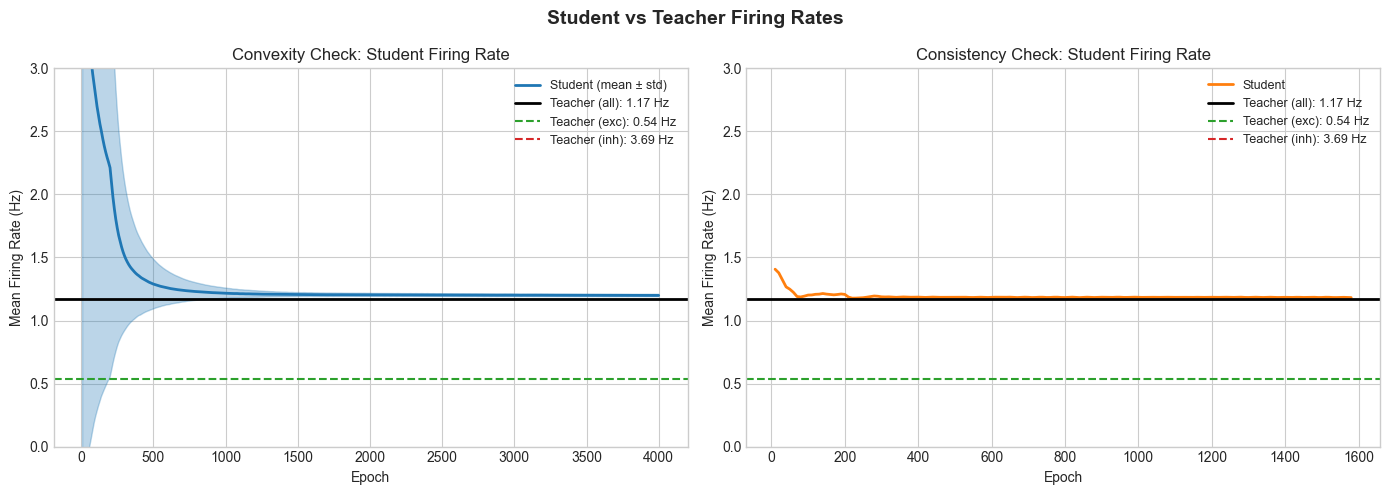

In [17]:
# Plot student firing rate trajectories vs teacher
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Convexity check - mean ± std of firing rate trajectories
ax = axes[0]

# Collect firing rate trajectories from all convexity check seeds
fr_trajectories = []
for seed in seeds:
    traj = trajectories[seed]
    # Load full metrics to get firing rate
    seed_dir = convexity_dir / f"convexity-check-seed-{seed}"
    metrics_df = pd.read_csv(seed_dir / "training_metrics.csv")
    fr_trajectories.append(metrics_df["firing_rate/mean"].values)

# Interpolate to common epoch grid
fr_all = []
for i, seed in enumerate(seeds):
    seed_dir = convexity_dir / f"convexity-check-seed-{seed}"
    metrics_df = pd.read_csv(seed_dir / "training_metrics.csv")
    epochs_seed = metrics_df["epoch"].values
    fr_seed = metrics_df["firing_rate/mean"].values
    
    if len(epochs_seed) != len(epochs_ref):
        fr_interp = np.interp(epochs_ref, epochs_seed, fr_seed)
    else:
        fr_interp = fr_seed
    fr_all.append(fr_interp)

fr_all = np.array(fr_all)
fr_mean = fr_all.mean(axis=0)
fr_std = fr_all.std(axis=0)

ax.fill_between(epochs_ref, fr_mean - fr_std, fr_mean + fr_std, alpha=0.3, color="C0")
ax.plot(epochs_ref, fr_mean, color="C0", linewidth=2, label="Student (mean ± std)")

# Teacher reference lines
ax.axhline(y=teacher_all_rate, color="black", linestyle="-", linewidth=2, label=f"Teacher (all): {teacher_all_rate:.2f} Hz")
ax.axhline(y=teacher_exc_rate, color="C2", linestyle="--", linewidth=1.5, label=f"Teacher (exc): {teacher_exc_rate:.2f} Hz")
ax.axhline(y=teacher_inh_rate, color="C3", linestyle="--", linewidth=1.5, label=f"Teacher (inh): {teacher_inh_rate:.2f} Hz")

ax.set_xlabel("Epoch")
ax.set_ylabel("Mean Firing Rate (Hz)")
ax.set_title("Convexity Check: Student Firing Rate")
ax.legend(loc="upper right", fontsize=9)
ax.set_ylim(0, 3)

# Right: Consistency check firing rate trajectory
ax = axes[1]

cons_fr = consistency_df["firing_rate/mean"].values
cons_epochs = consistency_df["epoch"].values

ax.plot(cons_epochs, cons_fr, color="C1", linewidth=2, label="Student")

# Teacher reference lines
ax.axhline(y=teacher_all_rate, color="black", linestyle="-", linewidth=2, label=f"Teacher (all): {teacher_all_rate:.2f} Hz")
ax.axhline(y=teacher_exc_rate, color="C2", linestyle="--", linewidth=1.5, label=f"Teacher (exc): {teacher_exc_rate:.2f} Hz")
ax.axhline(y=teacher_inh_rate, color="C3", linestyle="--", linewidth=1.5, label=f"Teacher (inh): {teacher_inh_rate:.2f} Hz")

ax.set_xlabel("Epoch")
ax.set_ylabel("Mean Firing Rate (Hz)")
ax.set_title("Consistency Check: Student Firing Rate")
ax.legend(loc="upper right", fontsize=9)
ax.set_ylim(0, 3)

plt.suptitle("Student vs Teacher Firing Rates", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

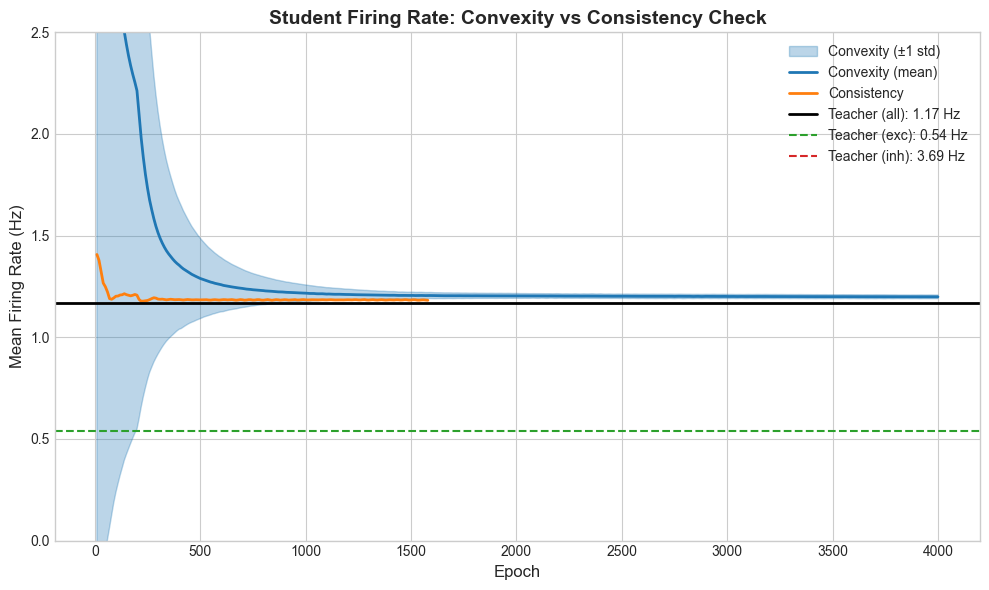


Final student firing rates:
  Convexity check (mean ± std): 1.199 ± 0.009 Hz
  Consistency check: 1.182 Hz
  Teacher (all): 1.168 Hz


In [18]:
# Combined plot: Convexity and consistency check firing rates together
fig, ax = plt.subplots(figsize=(10, 6))

# Convexity check - mean ± std
ax.fill_between(epochs_ref, fr_mean - fr_std, fr_mean + fr_std, alpha=0.3, color="C0", 
                label="Convexity (±1 std)")
ax.plot(epochs_ref, fr_mean, color="C0", linewidth=2, label="Convexity (mean)")

# Consistency check
ax.plot(cons_epochs, cons_fr, color="C1", linewidth=2, label="Consistency")

# Teacher reference lines
ax.axhline(y=teacher_all_rate, color="black", linestyle="-", linewidth=2, 
           label=f"Teacher (all): {teacher_all_rate:.2f} Hz")
ax.axhline(y=teacher_exc_rate, color="C2", linestyle="--", linewidth=1.5, 
           label=f"Teacher (exc): {teacher_exc_rate:.2f} Hz")
ax.axhline(y=teacher_inh_rate, color="C3", linestyle="--", linewidth=1.5, 
           label=f"Teacher (inh): {teacher_inh_rate:.2f} Hz")

ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Mean Firing Rate (Hz)", fontsize=12)
ax.set_title("Student Firing Rate: Convexity vs Consistency Check", fontsize=14, fontweight="bold")
ax.legend(loc="upper right")
ax.set_ylim(0, 2.5)

plt.tight_layout()
plt.show()

# Print final firing rates
print("\nFinal student firing rates:")
print(f"  Convexity check (mean ± std): {fr_mean[-1]:.3f} ± {fr_std[-1]:.3f} Hz")
print(f"  Consistency check: {cons_fr[-1]:.3f} Hz")
print(f"  Teacher (all): {teacher_all_rate:.3f} Hz")